# Introduction to Data Science – Homework 6
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 21 2019, 11:59pm.

In Part 1 of this homework you will scrape github repositories and organize the information in a Pandas dataframe. In Part 2, you will use linear regression to gain meaningful insights. 

## Your Data
First Name: Patricia
<br>
Last Name: Girardi
<br>
E-mail: u0894934@utah.edu
<br>
UID: u0894934
<br>

# Preface: I am very sorry

<img src="mycode.png">

I wish I had the mental fortitude to go through this and clean it up. It's real messy but it works, and I'm kind of afraid of breaking it so I'm going to leave it. Sorry you have to grade this.

In [1]:
# imports and setup 
from bs4 import BeautifulSoup
# you can use either of these libraries to get html from a website
import time
import os

import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
# where the data is stored
DATA_PATH = "data"

### 1. Scrape Github Repository List using BeautifulSoup
In this part you will explore Github repositories, specifically the 100 most-starred repositories. You are going to scrape data from [this repository list](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories).

### 1.1. Check whether you are permitted to scrape the data
Before you start to scrape any website you should go through the terms of service and policy documents of the website. Almost all websites post conditions to use their data. Check the terms of [https://github.com/](https://github.com/) to see whether the site permits you to scrape their data or not. Are you sure you are allowed to scrape?

**Your solution:**
The terms have this statement: 
"Researchers may scrape public, non-personal information from the Service for research purposes, only if any publications resulting from that research are open access."
I believe this project counts as research, and I don't plan on making any publications from this assignment so **we good. B)**

### Task 1.2 Load the Data

To avoid any problems with GitHub blocking us from downloading the data many times, we have downloaded and saved all the html files in the [data](data) folder. You will be treating the data folder as your website to be scraped. The path to data folder is stored in `DATA_PATH` variable.

In the data folder you will find first 10 pages of highly starred repositories saved as `searchPage1.html`,`searchPage2.html`,`searchPage3.html` ... `searchPage10.html`

Check out page 10 if you want to see what happens if you scrape to quickly ;). 

Now read these html files in python and create a soup object. This is a two step process:
 * Read the text in the html files
 * Create the soup from the files that you've read. 
 
We recommend that you create a single soup using BeautifulSoups' [append()](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#append) function.

<html>
 <body>
  <p>
   foo
  </p>
 </body>
 <!DOCTYPE html>
 <html lang="en">
  <head>
   <meta charset="utf-8"/>
   <link href="https://github.githubassets.com" rel="dns-prefetch"/>
   <link href="https://avatars0.githubusercontent.com" rel="dns-prefetch"/>
   <link href="https://avatars1.githubusercontent.com" rel="dns-prefetch"/>
   <link href="https://avatars2.githubusercontent.com" rel="dns-prefetch"/>
   <link href="https://avatars3.githubusercontent.com" rel="dns-prefetch"/>
   <link href="https://github-cloud.s3.amazonaws.com" rel="dns-prefetch"/>
   <link href="https://user-images.githubusercontent.com/" rel="dns-prefetch"/>
   <link crossorigin="anonymous" href="https://github.githubassets.com/assets/frameworks-6548d5a1dd84bd83036c6a914b25b4ae.css" integrity="sha512-ZUjVod2EvYMDbGqRSyW0rpfgBq3i+gnR/4PfrzLsy5f20oIcRfgFQFVKgi3Ztp917bP1K/kdP5q8+nAlJ3+cFA==" media="all" rel="stylesheet"/>
   <link crossorigin="anonymous" href="https://github.githubassets.com/assets/site-1cd57b56
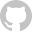
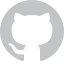

In [2]:
# I'm dealing with just the search pages for right now.

# I will make a list of the files so that I can easily loop thru BeautifulSoup

filelist = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.html'):
        filelist.append(DATA_PATH + '/' + file)

# just making a little placeholder soup so that I can append the actual soups to it.
soup = "foo"
soup = BeautifulSoup(soup)

# now appending soups
for file in filelist:
    newsoup = BeautifulSoup(open(file), "html.parser")
    soup.html.append(newsoup)

print(soup.prettify())

### 1.3. Extract Data

Extract the following data for each repository, and create a Pandas Dataframe with a row for each repository and a column for each of these datums. 

1. The name of the repository
+ The primary language (there are multiple or none, if multiple, use the first one, if none, use "none")
+ The number of watches
+ The number of stars
+ Number of forks
+ Number of commits
+ Number of branches
+ Number of contributors
+ Number of issues
+ Length of readme file.

Here's an example for one repository on how that data could look like: 
```python
{'name': 'Python-100-Days',
'language': 'Jupyter Notebook',
'stars': '78068',
'watches': '4822',
'forks': '30979',
'commits': 296,
'branches': 1,
'contributors': 12,
'issues': '224',
'readme': 11159}
```

Note that you will first have to extract links from the soup that you just scraped earlier. When you extract the link for the repository it will be a path to the stored html page for the repository. You will use this path to read the file and extract the above information.

Refer to the scraping lecture for details on how to do this. We recommend you use the web inspector to identify the relevant structures. 

Save the dataframe you created to a new file `project_info.csv` and ***include this in your submission***. You will loose points if you don't.

You also need to make sure that you reformat all numerical columns to be integer data. You can do that either as you parse, or when you have a dataframe with strings. 

Note that there is one repository flagged as having infinite contributers (the Linux kernel). We'll assume that it in fact has 15600 contributors (an estimate based on a google search). 

Another repository has "5000+" issues, we'll just assume it's 5000.

In [3]:
# here's some prep work for our soup
# aka mise en place in the culinary world

import re

# these aren't the real titles I'm using in the dataframe, this is just to get ready to make the soup
title = soup.find_all("a", class_="v-align-middle", href=True)
string_title = [tag.get_text(strip=True) for tag in title]

# now getting file paths so that I can parse thru the html files
fakeurls=[]
for a in title:
    fakeurls.append(a['href'])
    
# fake urls do not have the full file path

# below I'll concat the rest of the file path to the beginning of the fake url and append it to a new list
    
urls=[]
for fakeurl in fakeurls:
    url = "/Users/patriciagirardi/datascience homeworks/Girardi HW6/data/" + fakeurl
    urls.append(url)
urls[0]
# printing the first element so you can see what I did
# which is basically just making a list of the full file paths for each html file

'/Users/patriciagirardi/datascience homeworks/Girardi HW6/data/freeCodeCamp/freeCodeCamp.html'

In [4]:
# now I will make the big soup for real

#again creating an empty soup for my files to be appended to
bigboisoup = "foo"
bigboisoup = BeautifulSoup(bigboisoup)

# using the list of full file paths as my loop structure
for url in urls:
    newsoup = BeautifulSoup(open(url), "html.parser")
    bigboisoup.html.append(newsoup) 
bigboisoup.head()

[<meta charset="utf-8"/>,
 <link href="https://github.githubassets.com" rel="dns-prefetch"/>,
 <link href="https://avatars0.githubusercontent.com" rel="dns-prefetch"/>,
 <link href="https://avatars1.githubusercontent.com" rel="dns-prefetch"/>,
 <link href="https://avatars2.githubusercontent.com" rel="dns-prefetch"/>,
 <link href="https://avatars3.githubusercontent.com" rel="dns-prefetch"/>,
 <link href="https://github-cloud.s3.amazonaws.com" rel="dns-prefetch"/>,
 <link href="https://user-images.githubusercontent.com/" rel="dns-prefetch"/>,
 <link crossorigin="anonymous" href="https://github.githubassets.com/assets/frameworks-6548d5a1dd84bd83036c6a914b25b4ae.css" integrity="sha512-ZUjVod2EvYMDbGqRSyW0rpfgBq3i+gnR/4PfrzLsy5f20oIcRfgFQFVKgi3Ztp917bP1K/kdP5q8+nAlJ3+cFA==" media="all" rel="stylesheet">
 <link crossorigin="anonymous" href="https://github.githubassets.com/assets/site-1cd57b56e5c8f7c49216299a13bafc79.css" integrity="sha512-HNV7VuXI98SSFimaE7r8eVsgrmzC37AMNXw1GrNbOl4wN3ATov+Sd

In [5]:
# now to extract the data. we will start with the simplest one

name = bigboisoup.find_all("strong", itemprop="name")
names = [tag.get_text(strip=True) for tag in name]   #stripping out the html stuff with list comprehension
names[0]

'freeCodeCamp'

In [6]:
# next, let's find the number of stars for each repository
# this one was more complicated because the text was stored in an aria label

star = []
for a in bigboisoup.find_all("a", class_="social-count js-social-count", href=re.compile("stargazers")):
    star.append(a["aria-label"])
    
# using lambda to strip the "users starred this repository" text out of the string and make an int
stars = list(map(lambda sub:int(''.join(
[ele for ele in sub if ele.isnumeric()])), star))
stars[0]

308649

In [7]:
# repeating this method to find watches

watch = []
for a in bigboisoup.find_all("a", class_="social-count", href=re.compile("watchers")):
    watch.append(a["aria-label"])

watches = list(map(lambda sub:int(''.join(
[ele for ele in sub if ele.isnumeric()])), watch))
watches[0]

8376

In [8]:
# same deal for the forks

fork = []
for a in bigboisoup.find_all("a", class_="social-count", href = re.compile("members")):
    fork.append(a["aria-label"])

forks = list(map(lambda sub:int(''.join(
[ele for ele in sub if ele.isnumeric()])), fork))
forks[0]

23684

In [9]:
# finding commits
# switching methods here: no lambda, list comprehension instead
# I can't remember why I couldn't get lambda to work on this one, but here was my workaround

commits=[]

for url in urls:
    newsoup = BeautifulSoup(open(url), "html.parser")
    commit = newsoup.find("a", href = re.compile("commits")).get_text(strip=True)
    commits.append(commit)
    
commits2=[]
for i in commits:
    s = ''.join(x for x in i if x.isdigit())
    commits2.append(int(s))
commits2[0]

25355

In [10]:
# finding contributors (a little hacky, thanks to the infinity symbol)
# same method as above

contris = bigboisoup.find_all("a", href = re.compile("graphs/contributors"))
result = []
for contributor in contris:
    result.extend(contributor.find_all(class_="num text-emphasized"))
contributors = [tag.get_text(strip=True) for tag in result]
contributors[-12] = '15600'

contributors2=[]
for i in contributors:
    s = ''.join(x for x in i if x.isdigit())
    contributors2.append(int(s))
contributors2[0]

3999

In [11]:
# finding branches
# another method! yay!
# the try/except loop! this was my holy grail when I found out about it

branches = []

for url in urls:
    newsoup = BeautifulSoup(open(url), "html.parser")
    try:
        branch = newsoup.find("a", href = re.compile("branches")).get_text(strip=True)
    except:
        branch = "0"
    finally:
        branches.append(branch)
        
# used the same integer extraction method once the list was made
branches2=[]
for i in branches:
    s = ''.join(x for x in i if x.isdigit())
    branches2.append(int(s))
branches2[0]

5

In [12]:
# finding issues...(I have had many with this assignment...)
# once I found try/except, I didn't go back lol

issues = []
for url in urls:
    newsoup = BeautifulSoup(open(url), "html.parser")
    try:
        issue = newsoup.find("a", href = re.compile("issues"), class_="js-selected-navigation-item reponav-item").get_text(strip=True)
    except:
        issue = "0"
    finally:
        issues.append(issue)

issues2=[]
for i in issues:
    s = ''.join(x for x in i if x.isdigit())
    issues2.append(int(s))
issues2[0]

163

In [13]:
# get readme length
# this was where I had a full on mental breakdown 
# I didn't realize the readme was at the bottom of each repo page
# so I thought we had to scrape the README.md file from the repo too
# :')


readme = bigboisoup.find_all("div", class_="Box-body")
readme
lengths=[]
for i in readme:
    x = i.get_text(strip=True)
    lengths.append(len(x))
lengths[0]

6017

In [14]:
# finally...languages. This one was tricky too, I'm glad someone asked about it on slack

languages = []
for url in urls:
    newsoup = BeautifulSoup(open(url), "html.parser")
    try:
        language = newsoup.find("span", class_="lang").get_text(strip=True)
    except:
        language = "None"
    finally:
        languages.append(language)
languages[0]

'JavaScript'

# To recap:
1. I used 3 different methods to extract data. 
+ And 2 different methods to extract integers from strings.
+ Each attribute has its own loop.
+ Also, for some attributes I looped through each soup instead of once through the big soup 

Can you get any hackier? I think not.

*Sorry!!!!*

I saw a classmate's code. You know what he did? One loop for everything. It found all the attributes AND made a dictionary. In one loop. I hate him.

Now that my personal hell has been realized, let's move on to the more familiar stuff: creating a dataframe and doing analysis on it.

In [15]:
# We'll start by making a dictionary
dict = {"Name" : names,
       "Language" : languages,
       "Stars" : stars,
       "Watches" : watches,
       "Forks" : forks,
       "Commits" : commits2,
       "Branches" : branches2,
       "Contributors" : contributors2,
       "Issues" : issues2,
       "Readme" : lengths
}

# and now we'll read it into the dataframe
df = pd.DataFrame(dict)
df
# I cried a tear of joy when I finally saw all this info load into the df right

,Name,Language,Stars,Watches,Forks,Commits,Branches,Contributors,Issues,Readme
0,freeCodeCamp,JavaScript,308649,8376,23684,25355,5,3999,163,6017
1,996.ICU,Rust,249141,4523,21217,3019,1,605,0,4482
2,vue,JavaScript,156926,6012,23646,3085,44,289,291,2546
3,react,JavaScript,143727,6636,27597,12812,49,1361,483,3185
4,tensorflow,C++,140937,8485,79892,78840,33,2396,3102,3193
...,...,...,...,...,...,...,...,...,...,...
85,public-apis,Python,70648,2055,8017,2132,2,545,5,45480
86,axios,JavaScript,69633,1165,6167,905,8,199,284,17360
87,go,Go,68953,3422,9809,42513,37,1464,5000,1334
88,JavaGuide,Java,68806,3607,23514,2063,1,124,21,4083


In [16]:
df.to_csv('project_info.csv', index=False)

### 2. Analyzing the repository data

In this part, you will analyze the data collectd in Part 1 using regression tools. The goal is to identify properties that make a repository popular. 

First, load the `project_info.csv` file in again. **We need you to do this so that we can run your code below without having to run your scraping code, which can be slow.**

In [17]:
project_info = pd.read_csv('project_info.csv')
project_info.head()

,Name,Language,Stars,Watches,Forks,Commits,Branches,Contributors,Issues,Readme
0,freeCodeCamp,JavaScript,308649,8376,23684,25355,5,3999,163,6017
1,996.ICU,Rust,249141,4523,21217,3019,1,605,0,4482
2,vue,JavaScript,156926,6012,23646,3085,44,289,291,2546
3,react,JavaScript,143727,6636,27597,12812,49,1361,483,3185
4,tensorflow,C++,140937,8485,79892,78840,33,2396,3102,3193


### Task 2.1 Describe the data

+ Get an overview of the data using the describe function.
+ Compute the correlation matrix, visualize it with a heat map.
+ Visualize the correlations by making a scatterplot matrix.
+ Interprete what you see.

You can re-use code from your previous homework here.

In [18]:
project_info.describe()

,Stars,Watches,Forks,Commits,Branches,Contributors,Issues,Readme
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,71098.011111,2969.488889,15996.244444,22222.600000,33.433333,854.322222,694.222222,14992.888889
std,41043.124763,1840.600380,12584.938794,95797.079129,73.921770,1759.851838,1234.431642,28764.454405
min,43499.000000,336.000000,1148.000000,64.000000,1.000000,5.000000,0.000000,321.000000
25%,47328.250000,1571.250000,7888.250000,1324.750000,3.000000,151.250000,19.500000,2079.000000
50%,57690.000000,2535.500000,13968.500000,3267.500000,6.000000,428.500000,218.000000,3939.500000
75%,78957.500000,3584.250000,20091.750000,17243.750000,24.000000,1067.250000,491.750000,11074.500000
max,308649.000000,8564.000000,79892.000000,900539.000000,387.000000,15600.000000,5000.000000,170600.000000


In [19]:
project_info.dtypes
# just confirming all the digits are not strings faking it til they make it
# sometimes I feel like a string just faking it til I make it

Name            object
Language        object
Stars            int64
Watches          int64
Forks            int64
Commits          int64
Branches         int64
Contributors     int64
Issues           int64
Readme           int64
dtype: object

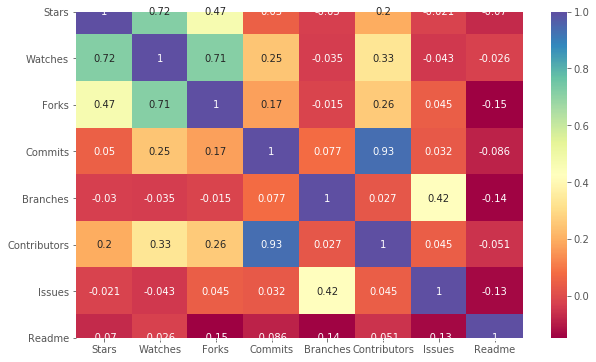

In [20]:
import seaborn as sns

corr = project_info.corr()

plot = sns.heatmap(corr, annot=True, cmap="Spectral")
# I chose this colormap because I think it's a little easier to read than others.

In [21]:
import altair as alt

alt.Chart(project_info).mark_circle(
).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    opacity=alt.value(0.3)
).properties(
    width=150,
    height=150
).repeat(
    row=["Stars", "Watches", "Forks", "Commits", "Branches", "Contributors", "Issues", "Readme"],
    column=["Stars", "Watches", "Forks", "Commits", "Branches", "Contributors", "Issues", "Readme"]
).interactive()

alt.RepeatChart(...)

**Your Interpretation:** Watches/stars, forks/watches, contributors/commits. These seem to be the relationships with the most correlation (from the heatmap). If you look at the scatter matrix, that relationship is a little harder to see (at least for watches/stars). Also, the scatter matrix shows what looks like a positive correlation between forks and stars, which the correlation matrix does not indicate. Not related to our end goal of estimating number of stars, but commits/contributors are really strongly tied together on the heatmap and not so much on the scatter matrix.

### 2.3. Linear regression

1. Use linear regression to try to predict the number of Stars based on Forks, Contributors, Issues, and Readme Length. Explain why this is not a very good model by discussing the R-squared , F-statistic p-value, and coefficient  p-values. 
+ Develop another model which is better. Explain why it is better and interpret your results. 

In [22]:
stars_ols = sm.ols(formula="Stars ~ Forks + Contributors + Issues + Readme", data=project_info).fit()
stars_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     6.228
Date:                Fri, 21 Feb 2020   Prob (F-statistic):           0.000192
Time:                        11:32:45   Log-Likelihood:                -1071.6
No. Observations:                  90   AIC:                             2153.
Df Residuals:                      85   BIC:                             2166.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.729e+04   7328.184      6.454      0.000    3.27e+04    6.19e+04
Forks            1.4617      0.326      4.487      0.000       0.814       2.109
Contributors     1.8560      2.308      0.804      0.423      -2.732       6.444
Issues          -1.5203      3.202     -0.475      0.636      -7.887       4.846
Readme          -0.0072      0.139     -0.052      0.958      -0.283       0.269
==============================================================================
Omnibus:                      104.604   Durbin-Watson:                   0.449
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1517.263
Skew:                           3.820   Prob(JB):                         0.00
Kurtosis:                      21.608   Cond. No.                     6.23e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Your interpretation:** Our R^2 is 0.190, so, right off the bat, we know this is a terrible model. <br>The p-value for our F-statistic is within acceptable range (p<0.05) by several orders of magnitude, but all that is telling us is that we're pretty sure this model is significant(ly crappy).<br>
The coefficient p-values are nothing exciting. We discount most of them as they're almost all p>0.05 The only one within acceptable range is the p-value for forks. The relationship there is that you can get ~1.46 stars for each fork. <br>

In [23]:
# Now I will attempt to develop a better model. 
newstars_ols = sm.ols(formula="Stars ~ Watches  + Commits + Contributors", data=project_info).fit()
newstars_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     39.38
Date:                Fri, 21 Feb 2020   Prob (F-statistic):           4.12e-16
Time:                        11:32:46   Log-Likelihood:                -1044.3
No. Observations:                  90   AIC:                             2097.
Df Residuals:                      86   BIC:                             2107.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept         2e+04   5532.864      3.615      0.001    9001.771     3.1e+04
Watches         15.3102      1.684      9.089      0.000      11.962      18.659
Commits         -0.2976      0.085     -3.507      0.001      -0.466      -0.129
Contributors    14.3361      4.746      3.021      0.003       4.901      23.771
==============================================================================
Omnibus:                       79.275   Durbin-Watson:                   1.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              748.057
Skew:                           2.682   Prob(JB):                    3.64e-163
Kurtosis:                      16.066   Cond. No.                     1.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation:** Okay, this is the best model I could come up with, and it's still not great. R^2 is at a solid 0.56 (explains 56% variability). However, the F-statistic p-value is miniscule, and the p-values for the attributes I chose are p<<0.05). This model, while not predicting that much of the variance in number of stars, does explain 56% of the variance in number of stars in a *significant* way. I think we still have some confounding factors here, or other variables that we haven't accounted for that are mucking up this model.